# Анализ токсичных коментариев с BERT
BERT (Bidirectional Encoder Representations from Transformers) — это языковая модель от Google (2018), как ясно из названия, ее оснонвная цель – кодирование текста (создание эмбеддингов) с сохранением контекста. Ее подвид, toxic-bert, мы будем использовать как feature extractor для классификации токсичных комментариев.

## Установка зависимостей

In [1]:
!pip install detoxify -q

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    make_scorer,
    average_precision_score)
import torch
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from detoxify import Detoxify
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

## Загрузка данных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
# Создаем класс датасета для обработки текстов в батчах
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True
        )
        return {key: value.squeeze(0) for key, value in inputs.items()}

In [6]:
# Dataloader для разбивки по батчам
def text_to_embedding_batched(texts, tokenizer, model, device, batch_size=700, max_length=128):
    dataset = TextDataset(texts, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Processing Batches'):
            batch = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**batch)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)

In [7]:
from sklearn.metrics import average_precision_score
import numpy as np
import torch

def evaluate_pr_auc(model, X, y, batch_size=32, device="cuda"):
    model.eval()
    scores = []
    true_labels = []

    num_batches = int(np.ceil(len(X) / batch_size))

    with torch.no_grad():
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, len(X))

            X_batch = X[start:end].to(device)
            y_batch = y[start:end].to(device)

            logits = model(X_batch)
            prob_pos = torch.softmax(logits, dim=1)[:, 1]
            scores.extend(prob_pos.detach().cpu().numpy())
            true_labels.extend(y_batch.detach().cpu().numpy())

    pr_auc = average_precision_score(true_labels, scores)
    print("PR-AUC:", pr_auc)
    return pr_auc

In [8]:
def detoxify_with_progress(detoxify_model, data, description):
    results = []
    for text in tnrange(len(data), desc=description):
        result = detoxify_model.predict([data[text]])
        results.append(result)
    return results

## Исследование данных


Проверим балланс классов таргета

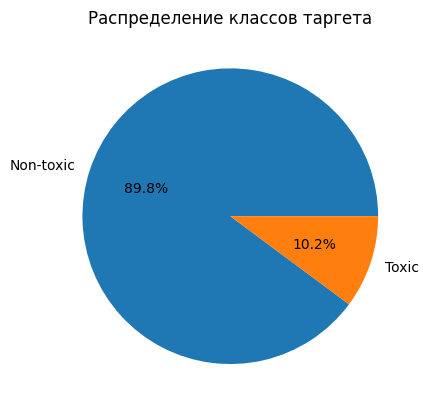

In [9]:
df['toxic'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Non-toxic', 'Toxic'])
plt.ylabel('')
plt.title('Распределение классов таргета')
plt.show()

Дисбалланс есть, но не катастрофический.

## ЛогРег на эмбэддингах BERT (базовая модель)

In [10]:
# Инициализация токенизатора и модели BERT
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')
bert_model = BertModel.from_pretrained('unitary/toxic-bert')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Разделение данных на обучающую и тестовую выборки
X = df['text'].values
y = df['toxic'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Получение эмбеддингов для обучающей и тестовой выборок с батчами
X_train_embeddings = text_to_embedding_batched(
    X_train, tokenizer, bert_model, device)
X_test_embeddings = text_to_embedding_batched(
    X_test, tokenizer, bert_model, device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Processing Batches:   0%|          | 0/46 [00:00<?, ?it/s]

In [11]:
model = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.01, 0.1]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv
)

grid.fit(X_train_embeddings, y_train)

print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучший PR-AUC на CV: {grid.best_score_}")

Лучшие параметры: {'C': 0.1}
Лучший PR-AUC на CV: 0.981465790297953


**Вывод**

Валидация показывает высокий результат в 0.98 по метрике PR-AUC.

## Полносвязная нейросеть на эмбэддингах BERT

In [12]:
# Создадим валидационные выборки
X_train, X_val, y_train, y_val = train_test_split(X_train_embeddings, y_train, test_size=0.2, random_state=42)

# Преобразуем в тензоры для использования с PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Определение MLP-модели
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Инициализация модели
input_size = X_train_embeddings.shape[1]  # Размер эмбеддинга
hidden_size = 128  # Количество нейронов в скрытом слое
output_size = 2  # Количество классов
model = MLP(input_size, hidden_size, output_size)

# Использование GPU при наличии
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для обучения
def train_epoch(model, X, y, optimizer, criterion, batch_size=32):
    model.train()
    total_loss = 0
    num_batches = int(np.ceil(len(X) / batch_size))

    for i in tnrange(num_batches, desc="Training"):
        start = i * batch_size
        end = start + batch_size
        X_batch = X[start:end].to(device)
        y_batch = y[start:end].to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / num_batches

# Функция для валидации
def evaluate_epoch(model, X, y, criterion, batch_size=32):
    model.eval()
    total_loss = 0
    true_labels = []
    scores = []

    num_batches = int(np.ceil(len(X) / batch_size))

    with torch.no_grad():
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, len(X))

            X_batch = X[start:end].to(device)
            y_batch = y[start:end].to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item()

            probs = torch.softmax(logits, dim=1)[:, 1]
            scores.extend(probs.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())

    pr_auc = average_precision_score(true_labels, scores)
    return total_loss / num_batches, pr_auc

# Основной цикл обучения
epochs = 10
batch_size = 32

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size)
    val_loss, val_PR = evaluate_epoch(model, X_val_tensor, y_val_tensor, criterion, batch_size)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PR-AUC: {val_PR:.4f}")

Epoch 1/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0424 | Val Loss: 0.0372 | Val PR-AUC: 0.9822
Epoch 2/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0402 | Val Loss: 0.0364 | Val PR-AUC: 0.9825
Epoch 3/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0393 | Val Loss: 0.0364 | Val PR-AUC: 0.9826
Epoch 4/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0389 | Val Loss: 0.0361 | Val PR-AUC: 0.9826
Epoch 5/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0383 | Val Loss: 0.0359 | Val PR-AUC: 0.9828
Epoch 6/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0380 | Val Loss: 0.0358 | Val PR-AUC: 0.9831
Epoch 7/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0376 | Val Loss: 0.0366 | Val PR-AUC: 0.9823
Epoch 8/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0372 | Val Loss: 0.0362 | Val PR-AUC: 0.9830
Epoch 9/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0372 | Val Loss: 0.0362 | Val PR-AUC: 0.9831
Epoch 10/10


Training:   0%|          | 0/3186 [00:00<?, ?it/s]

Train Loss: 0.0367 | Val Loss: 0.0357 | Val PR-AUC: 0.9831


**Вывод по предсказаниям**

Применение нейросети дало примерно такую же метрику (0.983), что и логистическая регрессия.

## Detoxify и логистическая регрессия

Detoxify – это готовая NLP-модель, основанная на BERT, оценивающая токсичность текста и возвращающая оценку текста по нескольким параметрам: "toxicity", "severe_toxicity", "obscene", "threat", "insult" и "identity_attack".

Используем эти оценки как входные признаки для ЛогРега, чтобы получить классификатор и посмотрим на метрику.

In [14]:
# Разделение данных
X = df['text'].values
y = df['toxic'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Создание признаков
detoxify_model = Detoxify('original', device=device)
X_train_dt = detoxify_with_progress(detoxify_model, list(X_train), "Processing X_train")
X_val_dt = detoxify_with_progress(detoxify_model, list(X_val), "Processing X_val")
X_test_dt = detoxify_with_progress(detoxify_model, list(X_test), "Processing X_test")

# Преобразование в DataFrame
X_train_dt_df = pd.DataFrame(X_train_dt)
X_val_dt_df = pd.DataFrame(X_val_dt)
X_test_dt_df = pd.DataFrame(X_test_dt)

Processing X_train:   0%|          | 0/108318 [00:00<?, ?it/s]

Processing X_val:   0%|          | 0/27080 [00:00<?, ?it/s]

Processing X_test:   0%|          | 0/23894 [00:00<?, ?it/s]

In [15]:
# Преобразуем списки в числа
X_train_dt_df = X_train_dt_df.applymap(
    lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
X_val_dt_df = X_val_dt_df.applymap(
    lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
X_test_dt_df = X_test_dt_df.applymap(
    lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

/tmp/ipython-input-1202535829.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train_dt_df = X_train_dt_df.applymap(
/tmp/ipython-input-1202535829.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val_dt_df = X_val_dt_df.applymap(
/tmp/ipython-input-1202535829.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test_dt_df = X_test_dt_df.applymap(


In [19]:
# Валидация
clf = LogisticRegression()
clf.fit(X_train_dt_df, y_train)

# Оценка на валидационной выборке
pred_val = clf.predict_proba(X_val_dt_df)[:, 1]
print('PR-AUC на валидации:', average_precision_score(y_val, pred_val))

PR-AUC на валидации: 0.9846342910183936


## Тестирование

In [21]:
clf = LogisticRegression()
clf.fit(X_train_dt_df, y_train)

# Оценка на тестовой выборке
pred_test = clf.predict_proba(X_test_dt_df)[:, 1]
print('PR-AUC на тесте:', average_precision_score(y_test, pred_test))

PR-AUC на тесте: 0.9863914882709021


## **Итоги**

По итогам проекта моделью логистической регрессии была достигнута метрика F1-Score в 0.94, модель использовала в качестве признаков результаты предсказания по исходным данным моделью Toxic-BERT, специально обученной на подобной задаче. В ходе проекта так же были рассмотрены нейросеть и логистическая регрессия на эмбеддингах BERT, однако, в следствии того, что классические токенизаторы BERT обучаются на менее специфичных данных, модели не превзошли результатов Toxic-BERT.